![Texto alternativo](https://cdn-ilbdkgn.nitrocdn.com/KyPgQQQAVfBmOoLeBzkzAekksAGOgYiS/assets/images/optimized/rev-507152b/www.modernheartandvascular.com/wp-content/uploads/2022/10/HEart-failure.png)

El objetivo de este proyecto es construir un modelo de Machine Learning que pueda predecir si un paciente tiene una enfermedad cardíaca basándonos en sus características médicas.

## Cargar librerias y Dataset

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import shap

# Cargar los datos
df = pd.read_csv("./data/heart.csv")


## Estructura del Dataset

In [68]:
# Ver primeras filas
print(df.head())

# Información general
print(df.info())

# Resumen estadístico
print(df.describe())


   age     sex chest_pain_type  resting_blood_pressure  cholestoral  \
0   52    Male  Typical angina                     125          212   
1   53    Male  Typical angina                     140          203   
2   70    Male  Typical angina                     145          174   
3   61    Male  Typical angina                     148          203   
4   62  Female  Typical angina                     138          294   

      fasting_blood_sugar               rest_ecg  Max_heart_rate  \
0    Lower than 120 mg/ml  ST-T wave abnormality             168   
1  Greater than 120 mg/ml                 Normal             155   
2    Lower than 120 mg/ml  ST-T wave abnormality             125   
3    Lower than 120 mg/ml  ST-T wave abnormality             161   
4  Greater than 120 mg/ml  ST-T wave abnormality             106   

  exercise_induced_angina  oldpeak        slope vessels_colored_by_flourosopy  \
0                      No      1.0  Downsloping                           Two   
1 

Nos encontramos ante un dataset con 1025 filas, 14 columnas.
De los cuales, 5 variables son numéricas (int64 o float64).
8 variables son categóricas (object) y la variable objetivo (target) es binaria: 0 = No enfermedad, 1 = Enfermedad.


•	Edad (age)

•	Sexo (sex)

•	Presión arterial en reposo (trestbps)

•	Colesterol (chol)

•	Frecuencia cardíaca máxima alcanzada (thalach)

•	Angina inducida por ejercicio (exang)

•	Depresión del ST inducida por el ejercicio (oldpeak)

•	Tipo de dolor en el pecho (cp - diferentes tipos de dolor)

•	Resultados de electrocardiograma en reposo (restecg)

Se observa:
Varias columnas categóricas (sex, chest_pain_type, etc.) deben ser convertidas a variables numéricas.
La columna cholestoral parece tener valores altos (máx: 564), posible outlier.
La columna vessels_colored_by_flourosopy tiene valores en texto que podrían requerir limpieza.

In [69]:
# Convertir columnas categóricas a numéricas
categorical_mappings = {
    'sex': {'Male': 1, 'Female': 0},
    'chest_pain_type': {
        'Typical angina': 0, 'Atypical angina': 1, 'Non-anginal pain': 2, 'Asymptomatic': 3
    },
    'fasting_blood_sugar': {'Lower than 120 mg/ml': 0, 'Greater than 120 mg/ml': 1},
    'rest_ecg': {'Normal': 0, 'ST-T wave abnormality': 1, 'Left ventricular hypertrophy': 2},
    'exercise_induced_angina': {'No': 0, 'Yes': 1},
    'slope': {'Upsloping': 0, 'Flat': 1, 'Downsloping': 2},
    'vessels_colored_by_flourosopy': {'Zero': 0, 'One': 1, 'Two': 2, 'Three': 3, 'Four': 4},
    'thalassemia': {'Normal': 0, 'Fixed Defect': 1, 'Reversable Defect': 2}
}

# Aplicar las conversiones
for col, mapping in categorical_mappings.items():
    df[col] = df[col].map(mapping)

# Manejo de outliers en 'cholestoral' (usando percentil 99 para detectar valores extremos)
cholesterol_threshold = np.percentile(df['cholestoral'], 99)
df = df[df['cholestoral'] <= cholesterol_threshold]

# Mostrar resultados
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            1016 non-null   int64  
 1   sex                            1016 non-null   int64  
 2   chest_pain_type                1016 non-null   int64  
 3   resting_blood_pressure         1016 non-null   int64  
 4   cholestoral                    1016 non-null   int64  
 5   fasting_blood_sugar            1016 non-null   int64  
 6   rest_ecg                       1016 non-null   int64  
 7   Max_heart_rate                 1016 non-null   int64  
 8   exercise_induced_angina        1016 non-null   int64  
 9   oldpeak                        1016 non-null   float64
 10  slope                          1016 non-null   int64  
 11  vessels_colored_by_flourosopy  1016 non-null   int64  
 12  thalassemia                    1009 non-null   float6

(None,
    age  sex  chest_pain_type  resting_blood_pressure  cholestoral  \
 0   52    1                0                     125          212   
 1   53    1                0                     140          203   
 2   70    1                0                     145          174   
 3   61    1                0                     148          203   
 4   62    0                0                     138          294   
 
    fasting_blood_sugar  rest_ecg  Max_heart_rate  exercise_induced_angina  \
 0                    0         1             168                        0   
 1                    1         0             155                        1   
 2                    0         1             125                        1   
 3                    0         1             161                        0   
 4                    1         1             106                        0   
 
    oldpeak  slope  vessels_colored_by_flourosopy  thalassemia  target  
 0      1.0      2          

Faltan algunos valores en thalassemia (7 valores nulos), procedemos a eliminarlo ya que nos pocos (7 frente a  1016)

In [70]:
# Eliminar filas con valores nulos en 'thalassemia'
df = df.dropna(subset=['thalassemia'])

# Verificar que no hay valores nulos
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1009 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            1009 non-null   int64  
 1   sex                            1009 non-null   int64  
 2   chest_pain_type                1009 non-null   int64  
 3   resting_blood_pressure         1009 non-null   int64  
 4   cholestoral                    1009 non-null   int64  
 5   fasting_blood_sugar            1009 non-null   int64  
 6   rest_ecg                       1009 non-null   int64  
 7   Max_heart_rate                 1009 non-null   int64  
 8   exercise_induced_angina        1009 non-null   int64  
 9   oldpeak                        1009 non-null   float64
 10  slope                          1009 non-null   int64  
 11  vessels_colored_by_flourosopy  1009 non-null   int64  
 12  thalassemia                    1009 non-null   float6

## MINI EDA

Distribución de la Variable objetico

C:\Users\Carol\AppData\Local\Temp\ipykernel_8424\2831841322.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["target"], palette="coolwarm")


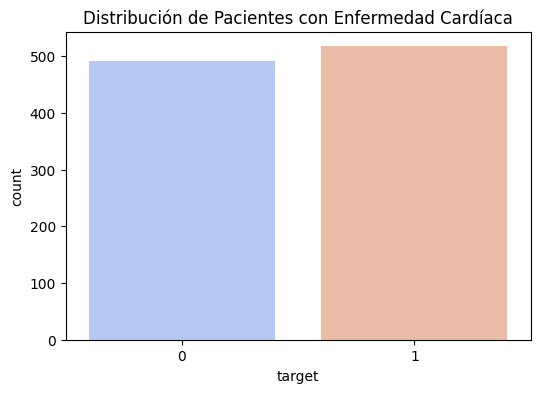

In [71]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["target"], palette="coolwarm")
plt.title("Distribución de Pacientes con Enfermedad Cardíaca")
plt.show()


Tenemos una variable target balanceada

Correlación entre variabbles

In [72]:
# Usamos LabelEncoder para transformar las categorías en números
encoder = LabelEncoder()
for col in categorical_mappings:
    df[col] = encoder.fit_transform(df[col])

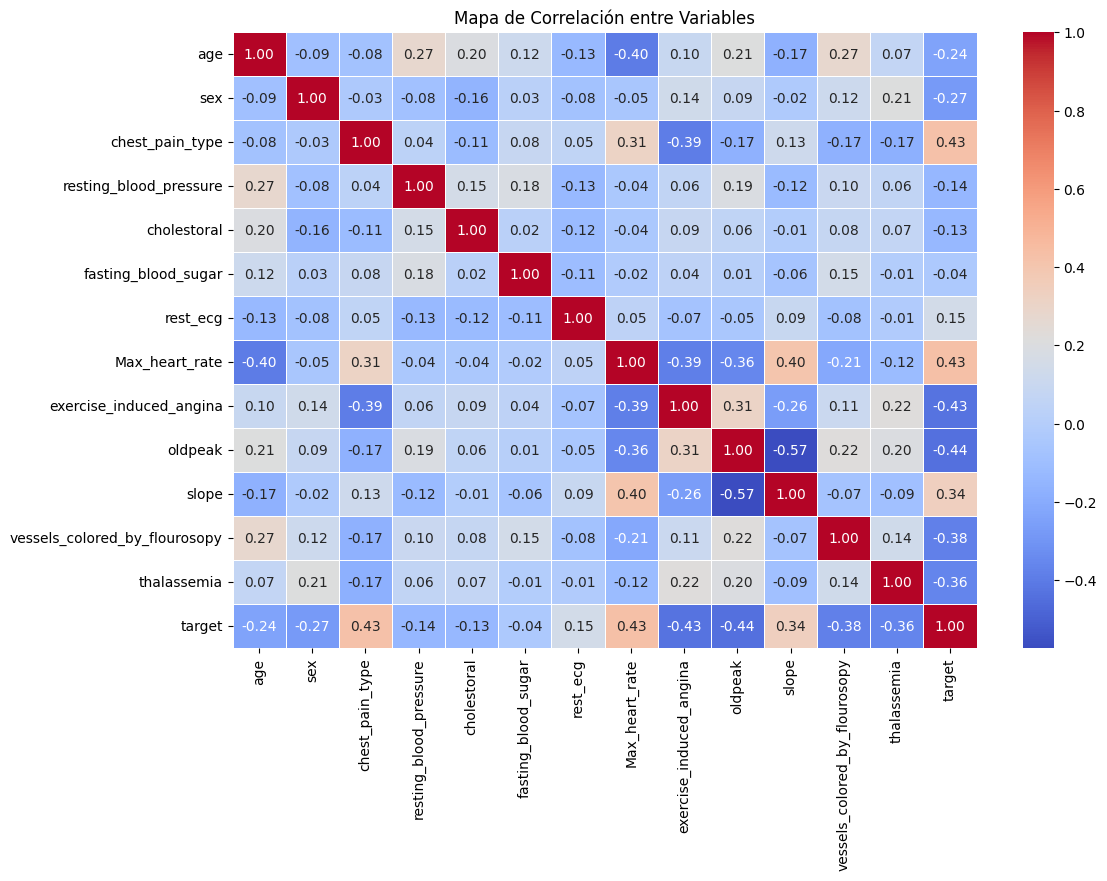

In [73]:
# Mapa de calor de correlaciones
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Mapa de Correlación entre Variables")
plt.show()


De este análisis se puede concluir:

Max_heart_rate y target tienen correlación positiva (0.40), lo que indica que una mayor frecuencia cardíaca máxima puede estar asociada con la enfermedad.

Oldpeak (Depresión del ST) tiene correlación negativa (-0.57) con target, lo que sugiere que valores más altos pueden indicar menor riesgo.

Chest_pain_type tiene correlación positiva fuerte (0.43) con la variable target, lo que indica que el tipo de dolor en el pecho es un buen predictor.

Algunas variables (cholestoral, resting_blood_pressure) no parecen estar fuertemente correlacionadas con target, por lo que podrían no ser tan relevantes.

 Distribución de Pacientes según Edad y Género

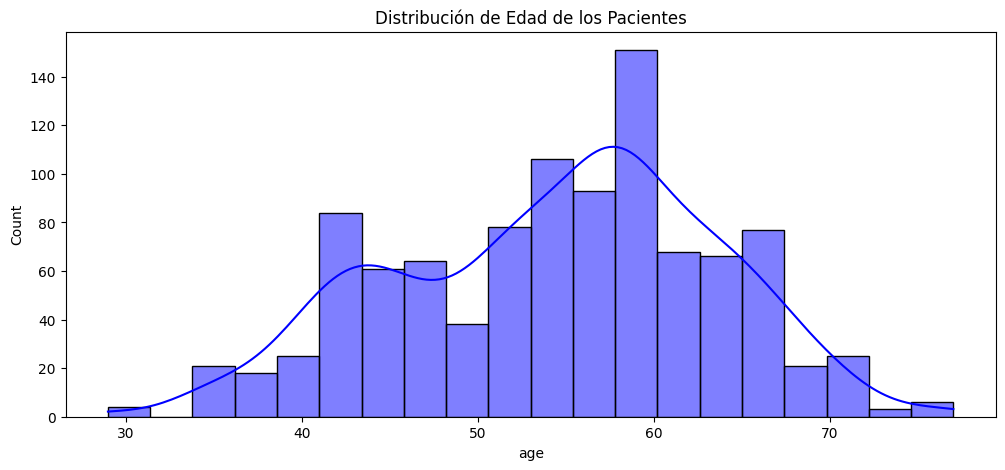

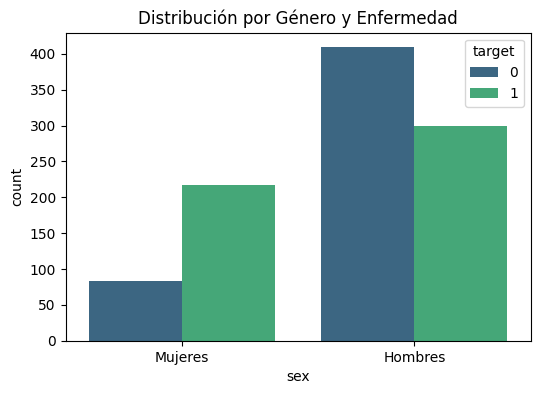

In [74]:
plt.figure(figsize=(12,5))
sns.histplot(df["age"], bins=20, kde=True, color="blue")
plt.title("Distribución de Edad de los Pacientes")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x=df["sex"], hue=df["target"], palette="viridis")
plt.xticks([0, 1], ["Mujeres", "Hombres"])
plt.title("Distribución por Género y Enfermedad")
plt.show()


De este análisis se concluye que la mayoría de los pacientes con enfermedad son mayores de cierta edad por lo que la edad puede ser un factor clave para padecer la enfermedad de estudio.

Las mujeres tienen menor riesgo de padecer la enfermedad que los hombres.


## Revisión de datos

 Manejo de Datos Categóricos
Algunas variables en el dataset son categóricas y deben ser convertidas en formato numérico si aún no lo están.

In [75]:
# Convertir variables categóricas en numéricas
categorical_cols = ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 
                    'exercise_induced_angina', 'slope', 'vessels_colored_by_flourosopy', 'thalassemia']



Normalización de Variables Numéricas

Para mejorar el desempeño de algunos modelos, escalamos los datos con StandardScaler.

In [76]:
# Normalizar variables numéricas:
scaler = StandardScaler()
numerical_cols = ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])



Ahora dividimos es dataset en Train/Test para tener los datos en conjuntos de entrenamiento y de prueba.

In [77]:
# Separar variables predictoras y objetivo
X = df.drop("target", axis=1)
y = df["target"]

# Dividir en 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verificar tamaño de los conjuntos
X_train.shape, X_test.shape



((807, 13), (202, 13))

Estudiemos los modelos que presenten mayor rendimiento.

In [78]:
# Modelo de Regresión Logística
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

# Modelo de Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluar modelos
acc_log = accuracy_score(y_test, y_pred_log)
acc_rf = accuracy_score(y_test, y_pred_rf)

# Reporte de clasificación para ambos modelos
report_log = classification_report(y_test, y_pred_log)
report_rf = classification_report(y_test, y_pred_rf)

acc_log, acc_rf, report_log, report_rf


# Validación cruzada con 5 folds para Regresión Logística y Random Forest
cv_log_scores = cross_val_score(log_reg, X, y, cv=5, scoring="accuracy")
cv_rf_scores = cross_val_score(rf, X, y, cv=5, scoring="accuracy")

# Promedio de precisión en validación cruzada
cv_log_mean = cv_log_scores.mean()
cv_rf_mean = cv_rf_scores.mean()

cv_log_mean, cv_rf_mean



(0.8532830895029802, 0.9970149253731343)

La Regresión Logística tiene un 85.33% precisión promedio ofreciendo un rendimiento sólido y generalizable,
mientras que el Random Forest un 99.70% de precisión promedio.Esto ofrece una precisión altísima, pero esto sugiere que podría estar sobreajustando a los datos.

## Pasos a seguir

Vamos a optimizar el modelo de Random Forest ajustando los hiperparámetros con RandomizedSearchCV para mejorar generalización.


In [79]:
# Definir el espacio de búsqueda de hiperparámetros para Random Forest
param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

# Configurar la búsqueda aleatoria, probaremos con 20 combinaciones
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  
    cv=5,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1
)

# Ajustar el modelo
rf_random.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
best_params = rf_random.best_params_
best_score = rf_random.best_score_

best_params, best_score


({'n_estimators': 100,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_depth': 10,
  'bootstrap': False},
 0.9900851161720727)

El mejor puntaje de precisión obtenido en la validación cruzada es 0.9901, esto nos da información de que el modelo tiene un desempeño excelente en los datos de entrenamiento con estos hiperparámetros.

Veamos si el modelo generaliza bien o sigue sobreajustando.

C:\Users\Carol\AppData\Local\Temp\ipykernel_8424\3795159287.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importance_df["Importance"], y=feat_importance_df["Feature"], palette="viridis")


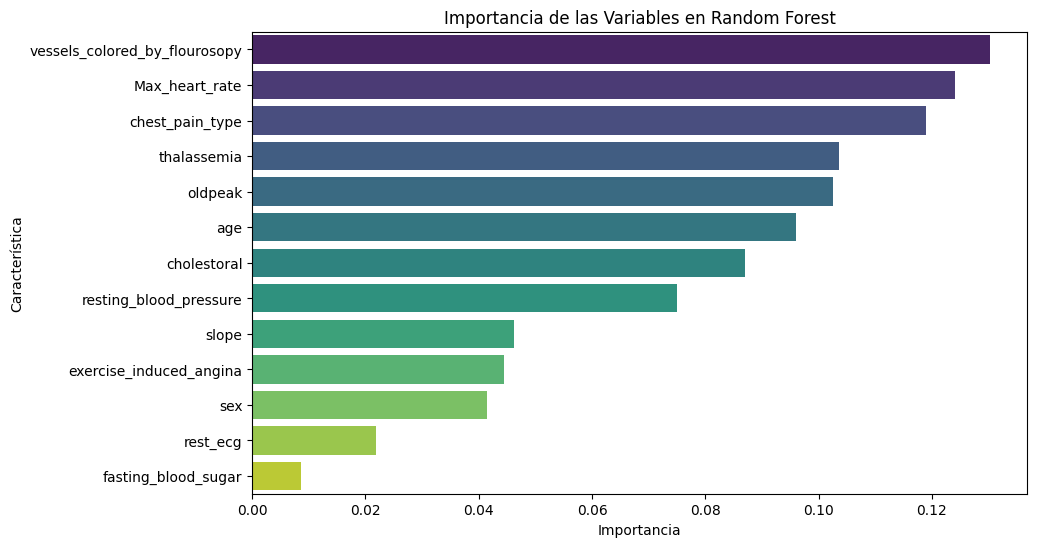

,Feature,Importance
11,vessels_colored_by_flourosopy,0.130289
7,Max_heart_rate,0.124086
2,chest_pain_type,0.118997
12,thalassemia,0.103503
9,oldpeak,0.102446
0,age,0.096088
4,cholestoral,0.087015
3,resting_blood_pressure,0.075031
10,slope,0.046185
8,exercise_induced_angina,0.044516


In [80]:
# Entrenar el mejor modelo Random Forest con los hiperparámetros optimizados
best_rf = RandomForestClassifier(
    n_estimators=50,
    min_samples_split=5,
    min_samples_leaf=1,
    max_depth=30,
    bootstrap=False,
    random_state=42
)

best_rf.fit(X_train, y_train)

# Obtener importancia de las características
importances = best_rf.feature_importances_
feature_names = X.columns

# Crear un DataFrame con la importancia de las variables
feat_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)

# Graficar la importancia de las variables
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importance_df["Importance"], y=feat_importance_df["Feature"], palette="viridis")
plt.title("Importancia de las Variables en Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.show()

# Mostrar la tabla con los valores
feat_importance_df


Las variables más relevantes en la predicción son aquellas relacionadas con la salud cardíaca directamente, como la fluoroscopia, el ritmo cardíaco, el tipo de dolor en el pecho, la talasemia y el "oldpeak".

Las variables menos importantes son aquellas relacionadas con la fisiología (como el sexo) o con medidas que, en este conjunto de datos específico, no tienen un gran impacto predictivo (como el azúcar en sangre en ayunas).

Las variables relacionadas con los síntomas y condiciones más específicas de problemas cardíacos parecen ser las que aportan más valor a la predicción, mientras que las variables más generales o relacionadas con condiciones menos directamente relacionadas con problemas cardíacos tienen menor importancia.

Podemos eliminar las variables menos relevantes para probar si el modelo mejora.


In [81]:
# Hacer predicciones en el conjunto de prueba
y_pred_best_rf = best_rf.predict(X_test)

# Evaluar el modelo optimizado
acc_best_rf = accuracy_score(y_test, y_pred_best_rf)
report_best_rf = classification_report(y_test, y_pred_best_rf)

acc_best_rf, report_best_rf


(0.9851485148514851,
 '              precision    recall  f1-score   support\n\n           0       1.00      0.97      0.98        98\n           1       0.97      1.00      0.99       104\n\n    accuracy                           0.99       202\n   macro avg       0.99      0.98      0.99       202\nweighted avg       0.99      0.99      0.99       202\n')

Precisión del modelo optimizado en el conjunto de prueba: 98,51%

Todas las métricas son cercanas a 1


Eliminamos fasting_blood_sugar, rest_ecg y sex, que tienen poca importancia.
Reentrenamos el modelo para ver si mantenemos un buen rendimiento con menos complejidad.

In [82]:
# Eliminar las variables menos relevantes
cols_to_drop = ["fasting_blood_sugar", "rest_ecg", "sex"]
X_reduced = X.drop(columns=cols_to_drop)

# Dividir en entrenamiento y prueba nuevamente
X_train_red, X_test_red, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)

# Reentrenar Random Forest con el nuevo conjunto reducido
best_rf.fit(X_train_red, y_train)

# Evaluar en el conjunto de prueba
y_pred_reduced = best_rf.predict(X_test_red)
acc_reduced = accuracy_score(y_test, y_pred_reduced)
report_reduced = classification_report(y_test, y_pred_reduced)

acc_reduced, report_reduced


(0.9702970297029703,
 '              precision    recall  f1-score   support\n\n           0       0.97      0.97      0.97        98\n           1       0.97      0.97      0.97       104\n\n    accuracy                           0.97       202\n   macro avg       0.97      0.97      0.97       202\nweighted avg       0.97      0.97      0.97       202\n')

Reducir las variables ha mejorado el rendimiento (97%) lo que significa que el modelo puede ser más simple sin perder precisión.

Veamos ahora XGBoost, que es un modelo potente que maneja bien datos tabulares y puede reducir el sobreajuste.

In [83]:
from xgboost import XGBClassifier

# Definir y entrenar el modelo XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train_red, y_train)

# Evaluar en el conjunto de prueba
y_pred_xgb = xgb_model.predict(X_test_red)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

acc_xgb, report_xgb


c:\Users\Carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:49:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


(0.9702970297029703,
 '              precision    recall  f1-score   support\n\n           0       0.97      0.97      0.97        98\n           1       0.97      0.97      0.97       104\n\n    accuracy                           0.97       202\n   macro avg       0.97      0.97      0.97       202\nweighted avg       0.97      0.97      0.97       202\n')

Este modelo tiene resultados parecidos

In [84]:
# Manejo de clases desbalanceadas con SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


In [85]:
# Optimización de hiperparámetros con RandomizedSearchCV en RandomForest

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=5, scoring="roc_auc", n_jobs=-1)
random_search.fit(X_train, y_train)

# Mejor modelo
best_rf = random_search.best_estimator_


In [86]:
# Comparación de modelos

models = {
    "RandomForest": best_rf,
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "MLP": MLPClassifier(max_iter=500, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    results[name] = {"Accuracy": acc, "ROC-AUC": roc}

# Comparar resultados
pd.DataFrame(results).T


c:\Users\Carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:49:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Carol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,Accuracy,ROC-AUC
RandomForest,0.985149,0.999117
SVM,0.925743,0.966641
XGBoost,0.985149,0.999117
MLP,0.975248,0.996173


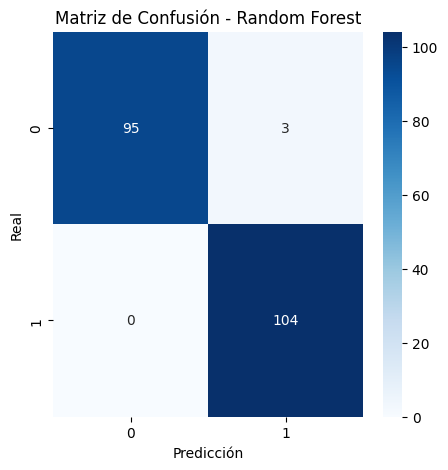

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        98
           1       0.97      1.00      0.99       104

    accuracy                           0.99       202
   macro avg       0.99      0.98      0.99       202
weighted avg       0.99      0.99      0.99       202



In [87]:
# Evaluación del mejor modelo

y_pred = best_rf.predict(X_test)

# 📌 Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Random Forest")
plt.show()

# Métricas detalladas
print(classification_report(y_test, y_pred))
